# Face Mask Detection

### Importing Packages

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils.paths import list_images
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt

### Defining Directories 

In [31]:
data_dir = "Data/"
plot_dir = "Results/plot.png"
model_dir = "Models/mask_detector.model"

### Loading the Dataset

In [12]:
print("[INFO] Loading Images...")
imagePaths = list(list_images(data_dir))
data = []
labels = []

[INFO] Loading Images...


In [13]:
for imagePath in imagePaths:
    label = imagePath.split('/')[-1].split('\\')[0]
    # print(label)

    image = load_img(imagePath, target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    data.append(image)
    labels.append(label)

### Data Preprocessing

In [14]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

trainX, testX,  trainY, testY = train_test_split(data, labels, test_size=0.2, 
                                                stratify=labels, random_state=42)

aug = ImageDataGenerator(rotation_range=20, 
                         zoom_range=0.15,
                         width_shift_range=0.2, 
                         height_shift_range=0.2,
                         shear_range=0.15, 
                         horizontal_flip=True, 
                         fill_mode='nearest')

### Defining the Model

In [17]:
baseModel = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [18]:
for layer in baseModel.layers:
    layer.trainable = False

### Model Parameters

In [21]:
INIT_LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32

### Compiling Model

In [22]:
print("[INFO] Compiling Model...")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

[INFO] Compiling Model...


D:\PROGRAMS\Miniconda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [23]:
print("[INFO] Training Head...")
head = model.fit(aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
                 steps_per_epoch = len(trainX) // BATCH_SIZE,
                 validation_data = (testX, testY),
                 validation_steps = len(testX) // BATCH_SIZE,
                 epochs = EPOCHS)

[INFO] Training Head...
Epoch 1/20
34/34 [==============================] - 60s 2s/step - loss: 0.4972 - accuracy: 0.7875 - val_loss: 0.2098 - val_accuracy: 0.9819
Epoch 2/20
34/34 [==============================] - 52s 2s/step - loss: 0.1758 - accuracy: 0.9738 - val_loss: 0.1063 - val_accuracy: 0.9783
Epoch 3/20
34/34 [==============================] - 55s 2s/step - loss: 0.1142 - accuracy: 0.9775 - val_loss: 0.0690 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 52s 2s/step - loss: 0.0732 - accuracy: 0.9897 - val_loss: 0.0516 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 55s 2s/step - loss: 0.0540 - accuracy: 0.9934 - val_loss: 0.0444 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 52s 2s/step - loss: 0.0497 - accuracy: 0.9869 - val_loss: 0.0354 - val_accuracy: 0.9891
Epoch 7/20
34/34 [==============================] - 52s 2s/step - loss: 0.0449 - accuracy: 0.9916 - val_loss: 0.0310 - val_accuracy: 0.9

### Model Evaluation 

In [29]:
print("[INFO] Evaluating Network...")

predIdxs = model.predict(testX, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis = 1), predIdxs, target_names = lb.classes_))

[INFO] Evaluating Network...
              precision    recall  f1-score   support

   with_mask       1.00      0.99      0.99       138
without_mask       0.99      1.00      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



### Saving the Model 

In [32]:
print("[INFO] Saving Model...")

model.save(model_dir, save_format = 'h5')

[INFO] Saving Model...


D:\PROGRAMS\Miniconda\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Showing Training & Validation Accuracies 

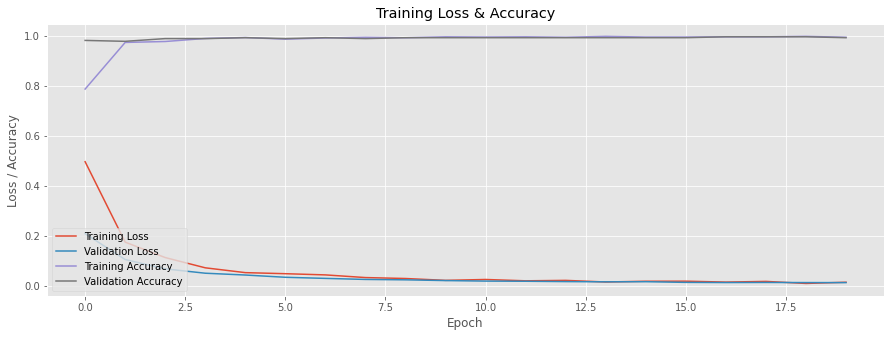

In [37]:
plt.style.use("ggplot")
plt.figure(figsize=(15,5))

plt.plot(np.arange(0, EPOCHS), head.history['loss'], label='Training Loss')
plt.plot(np.arange(0, EPOCHS), head.history['val_loss'], label='Validation Loss')
plt.plot(np.arange(0, EPOCHS), head.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(0, EPOCHS), head.history['val_accuracy'], label='Validation Accuracy')

plt.title("Training Loss & Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend(loc='lower left')
plt.savefig(plot_dir)